This is the notebook for unsupervised learning, as well as filter visualization

## Hyperparameters

In [1]:
# image size to downsample to
downsampled_size = 11

batch_size = 512

# margin for triplet loss function
margin = 2.

n_epochs = 200
# log every x batches
log_interval = 10

patch_size = 10
patch_stride = 1

# Convnet hyperparameters
lr = 1e-3
input_depth = 3
layer1_stride = 1
layer1_kernel_size = 6
layer1_output_channels = 256
layer1_padding = 0
use_relu = True

visualize_filter = True

# Number of examples to visualize and see how the network embeds
visualize_model_working = 0

## Dataset setup

In [2]:
from torchvision.datasets import CIFAR100
from torchvision import transforms
import utils
import torch

train_dataset = CIFAR100('./data/CIFAR100', train=True, download=True,
                             transform=transforms.Compose([
                                 transforms.RandomCrop(downsampled_size),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                             ]))
test_dataset = CIFAR100('./data/CIFAR100', train=False, download=True,
                            transform=transforms.Compose([
                                transforms.RandomCrop(downsampled_size),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                            ]))

cuda = torch.cuda.is_available()

kwargs = {'num_workers': 4, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

Files already downloaded and verified
Files already downloaded and verified


## ConvNet setup

In [3]:
import torch.optim as optim
from trainer import fit
from networks import EmbeddingNet, TripletNet, OnlineTripletNet, ConvEmbeddingNet, EmbeddingNetWithPooling
from losses import TripletLoss, OnlineTripletLoss
from utils import AllTripletSelector,HardestNegativeTripletSelector, \
    RandomNegativeTripletSelector, SemihardNegativeTripletSelector, RandomTripletSelector

In [4]:
embedding_net = EmbeddingNetWithPooling(input_depth=input_depth,
                             layer1_stride=layer1_stride,
                             layer1_kernel_size=layer1_kernel_size,
                             layer1_output_channels=layer1_output_channels,
                             layer1_padding=layer1_padding,
                             use_relu=use_relu)
model = ConvEmbeddingNet(embedding_net=embedding_net, patch_size=patch_size,
                         patch_stride=patch_stride, input_size=downsampled_size)
if cuda:
    model.cuda()

In [5]:
loss_fn = OnlineTripletLoss(margin, SemihardNegativeTripletSelector(margin))
val_loss_fn = OnlineTripletLoss(margin, RandomTripletSelector(margin))

optimizer = optim.Adam(model.parameters(), lr=lr)

# learning rate decay over epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, n_epochs // 1.5, gamma=0.1)

## Train and test model

In [ ]:
fit(train_loader, test_loader, model, loss_fn, optimizer, scheduler,
    n_epochs, cuda, log_interval, visualize_workings=visualize_model_working, val_loss_fn=val_loss_fn)

Train: [0/50000 (0%)]	Loss: 1.153743
Train: [10000/50000 (20%)]	Loss: 1.099696
Train: [20000/50000 (40%)]	Loss: 1.009626
Train: [30000/50000 (60%)]	Loss: 0.952215
Train: [40000/50000 (80%)]	Loss: 0.908268


## Save filter visualization

In [20]:
if visualize_filter:
    visualization_filename = "visualization_unsupervised_1l"
    # Reset
    open(visualization_filename, 'w').close()

    for filter in list(model.embedding_net.convnet.parameters())[0]:
        filter = utils.normalize_01(filter)
        utils.save_image_visualization(filter.detach().cpu().numpy(),
                                       filename=visualization_filename)

## Save first layer of model

In [21]:
torch.save(model.embedding_net.convnet[0].state_dict(), 'model_unsupervised_1l.pt')

## Visualize filters

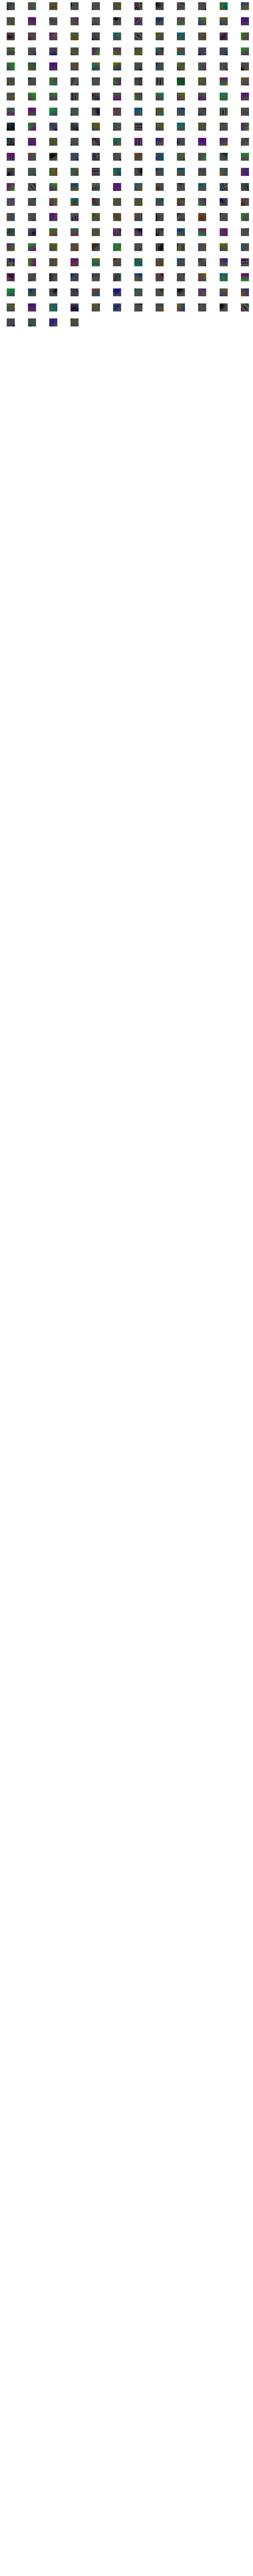

In [1]:
%matplotlib inline
import utils
filename = "visualization_unsupervised_1l"
utils.visualize_image_from_file2(filename)

## Compare to supervised CNN filters

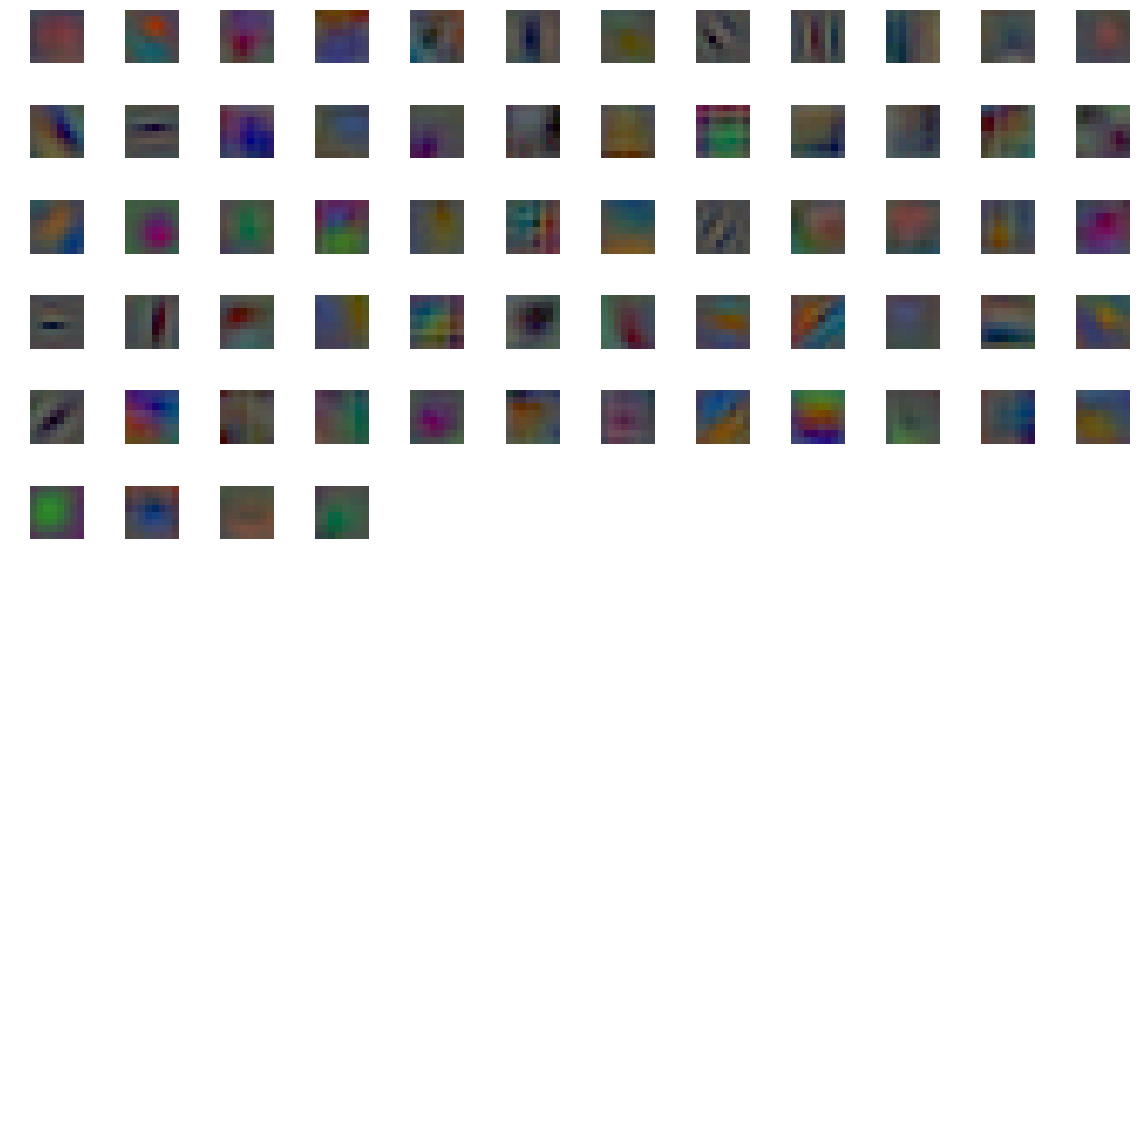

In [2]:
%matplotlib inline
import utils
filename = "visualization"
utils.visualize_image_from_file2(filename)